#### Loading and preparing the PCam data for training deep learning models using tensorflow dataset (tfds)

Loading the required libraries

In [53]:
import numpy as np
import tensorflow as tf
import time
# Please use the following line after importing TensorFlow to enable run function eagerly as you attempt
# to utilize the function decorator in TF 2.0:
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds

import pandas as pd

Defining a function that splits images and labels and one-hot-encodes the labels

In [2]:
def convert_sample(sample, mode):
    if mode == 'autoencoder':
        image, label = sample['image'], sample['image']
        image = tf.image.convert_image_dtype(image, tf.float32)
        label = tf.image.convert_image_dtype(label, tf.float32)
    elif mode == 'classifier':     
        image, label = sample['image'], sample['label']
        image = tf.image.convert_image_dtype(image, tf.float32)
        label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

## Loading data from your path
Remember to change to the correct destination

In [3]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = 'C:/Users/Manuel/Desktop/SDU - Data science/DS807 Anvendt Maskinlæring/eksamen',
                        download=False,
                        shuffle_files=True)

c:\Users\Manuel\anaconda3\envs\amlfall23\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Next we simple transform the data (by the function convert sample described previously) and getting ready for training by splitting it into batches.

In [4]:
train_dataset       = ds1.map(lambda x: convert_sample(x, 'autoencoder')).batch(32)
validation_dataset  = ds3.map(lambda x: convert_sample(x, 'autoencoder')).batch(32)
test_dataset        = ds2.map(lambda x: convert_sample(x, 'autoencoder')).batch(32)
 

### Defining a function that splits the dataset to x(images) and y(labels) 

In [5]:
#def split_dataset_2_xy(dataset):
#    x = []
#    y = []
#    for inputs, labels in dataset:
#        x.append(inputs.numpy())
#        y.append(labels.numpy())
#    # Convert lists to numpy arrays
#    x = np.concatenate(x, axis=0)
#    y = np.argmax(np.concatenate(y, axis=0),axis=1)
#    x = (tf.data.Dataset.from_tensor_slices(x).batch(32))
#    y = (tf.data.Dataset.from_tensor_slices(y).batch(32))
#    return x,y

Printing the dimentions of the datasplits

In [6]:
for batch in train_dataset.take(1):
    print(batch[0].shape)  # prints the shape of the inputs in the first batch
    print(batch[1].shape)  # prints the shape of the target in the first batch
for batch in validation_dataset.take(1):
    print(batch[0].shape)  # prints the shape of the inputs in the first batch
    print(batch[1].shape)  # prints the shape of the target in the first batch
for batch in test_dataset.take(1):
    print(batch[0].shape)  # prints the shape of the inputs in the first batch
    print(batch[1].shape)  # prints the shape of the target in the first batch

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


### Defining a function to plot the first 10 images

In [7]:
def plot_10(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title(str(i + 1))
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
    plt.show()

plotting the first 10 images in training set

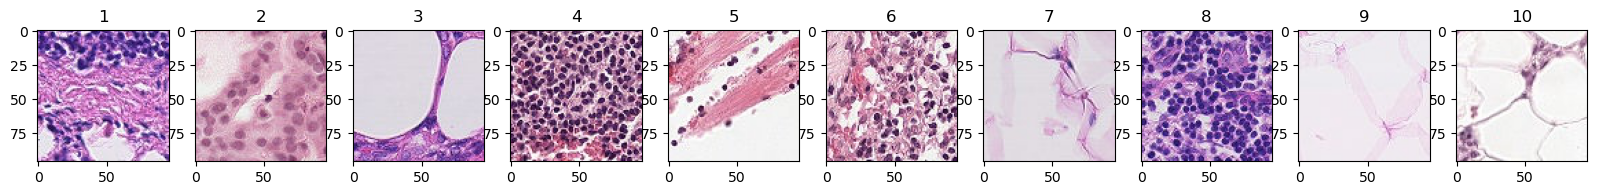

In [8]:
for batch in train_dataset.take(1):
    plot_10(batch[0])

# Defining our AE

creating af function to use in a hyperparameter selection setting

In [50]:
def create_autoencoder(nb_layers=2, nb_filters=[32,32], kernel_size=(3,3), input_shape=(96,96,3), batch_normalization=False, Regularization=None, optimizer='adam'):
    encoder = tf.keras.Sequential(name='encoder')
    encoder.add(tf.keras.layers.Conv2D(filters=nb_filters[0],
                                       kernel_size=kernel_size,
                                       strides=2, padding='same',
                                       activation='relu',
                                       input_shape=input_shape))
    for i in range(1,nb_layers):
        if Regularization == 'l1':
            encoder.add(tf.keras.layers.Conv2D(filters=nb_filters[i],
                                               kernel_size=kernel_size,
                                               strides=2,
                                               padding='same',
                                               activation='relu',
                                               activity_regularizer=tf.keras.regularizers.l1(10e-5)))
        elif Regularization == 'l2':
            encoder.add(tf.keras.layers.Conv2D(filters=nb_filters[i],
                                               kernel_size=kernel_size,
                                               strides=2,
                                               padding='same',
                                               activation='relu',
                                               activity_regularizer=tf.keras.regularizers.l2(10e-5)))
        else:
            encoder.add(tf.keras.layers.Conv2D(filters=nb_filters[i], kernel_size=kernel_size, strides=2, padding='same', activation='relu'))

        if batch_normalization == True:
            encoder.add(tf.keras.layers.BatchNormalization())
    
    encoder.add(tf.keras.layers.Conv2D(filters=1,
                                       kernel_size=kernel_size,
                                       strides=1,
                                       padding='same',
                                       activation='sigmoid'))
    
    decoder = tf.keras.Sequential(name='decoder')
    decoder.add(tf.keras.layers.Conv2DTranspose(filters=nb_filters[-1],
                                                kernel_size=kernel_size,
                                                strides=2, padding='same',
                                                activation='relu',
                                                input_shape=(input_shape[0]//2**nb_layers,input_shape[1]//2**nb_layers,1)))
    for i in range(nb_layers-2,-1,-1):
        if Regularization == 'l1':
            decoder.add(tf.keras.layers.Conv2DTranspose(filters=nb_filters[i],
                                                        kernel_size=kernel_size,
                                                        strides=2,
                                                        padding='same',
                                                        activation='relu',
                                                        activity_regularizer=tf.keras.regularizers.l1(10e-5)))
        elif Regularization == 'l2':
            decoder.add(tf.keras.layers.Conv2DTranspose(filters=nb_filters[i],
                                                        kernel_size=kernel_size,
                                                        strides=2,
                                                        padding='same',
                                                        activation='relu',
                                                        activity_regularizer=tf.keras.regularizers.l2(10e-5)))
        else:
            decoder.add(tf.keras.layers.Conv2DTranspose(filters=nb_filters[i], kernel_size=kernel_size, strides=2, padding='same', activation='relu'))
        if batch_normalization == True:
            decoder.add(tf.keras.layers.BatchNormalization())
        
    decoder.add(tf.keras.layers.Conv2DTranspose(filters=3,
                                                kernel_size=kernel_size,
                                                strides=1, padding='same',
                                                activation='sigmoid'))

    autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')
    autoencoder.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    #encoder.summary() #only use these when testing the function
    #decoder.summary() #only use these when testing the function
    
    return autoencoder

In [51]:
# testing the function create_autoencoder:
nb_layers = 4
nb_filters_list = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
nb_filters = nb_filters_list[0:nb_layers]
Regularization = 'l2'
batch_normalization = True
optimizer = 'adam'
model = create_autoencoder(nb_layers, nb_filters, kernel_size, input_shape, batch_normalization, Regularization, optimizer)
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 6, 6, 1)           29313     
                                                                 
 decoder (Sequential)        (None, 96, 96, 3)         29315     
                                                                 
Total params: 58,628
Trainable params: 58,244
Non-trainable params: 384
_________________________________________________________________


## Train our autoencoder


Creating and Training autoencoder-model with 3 layers in encoder and decoder, Regularization: l1, batch_normalization: True, optimizer: adam
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 12, 12, 1)         19937     
                                                                 
 decoder (Sequential)        (None, 96, 96, 3)         19939     
                                                                 
Total params: 39,876
Trainable params: 39,620
Non-trainable params: 256
_________________________________________________________________
1639/1639 [==============================] - 352s 214ms/step - loss: 0.0673 - mae: 0.2070 - val_loss: 0.0598 - val_mae: 0.2063
Training model with 3 layers done
loss:  0.05979212373495102
mae:  0.20628568530082703
1/1 [==============================] - 0s 108ms/step


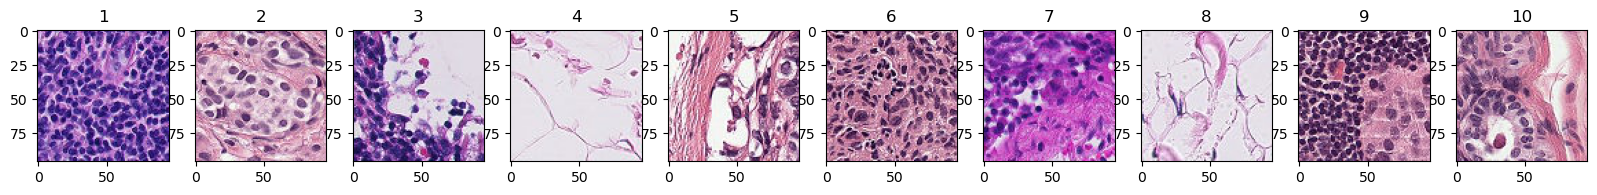

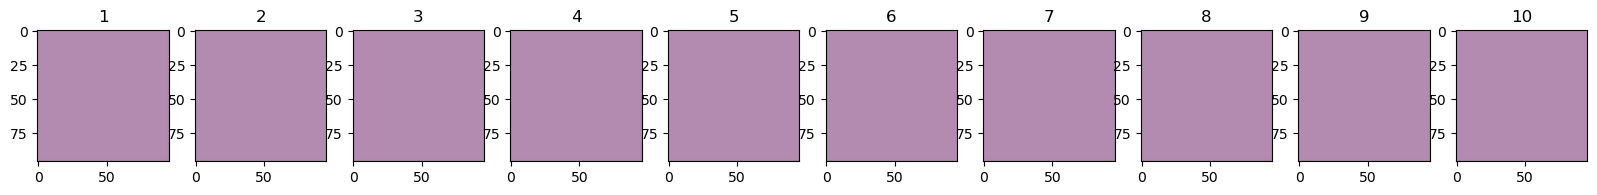

Creating and Training autoencoder-model with 3 layers in encoder and decoder, Regularization: l1, batch_normalization: True, optimizer: rmsprop
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 12, 12, 1)         19937     
                                                                 
 decoder (Sequential)        (None, 96, 96, 3)         19939     
                                                                 
Total params: 39,876
Trainable params: 39,620
Non-trainable params: 256
_________________________________________________________________
 136/1639 [=>............................] - ETA: 5:58 - loss: 0.1119 - mae: 0.2154

KeyboardInterrupt: 

In [124]:
# prepare list for storing results
train_loss = []
val_loss = []
train_mae = []
val_mae = []

# set epochs:
epochs = 20 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

# set parameters for autoencoder
nb_layers_list = [3,4]
nb_filters_list = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
Regularizations = [None, 'l2']
batch_normalizations = [True, False]
optimizers = ['adam','rmsprop','adagrad']

results = []

# train model and store results and test models
for nb_layers in nb_layers_list:
    for Regularization in Regularizations:
        for batch_normalization in batch_normalizations:
            for optimizer in optimizers:
                # create model
                print(f'Creating and Training autoencoder-model with {nb_layers} layers in encoder and decoder, Regularization: {Regularization}, batch_normalization: {batch_normalization}, optimizer: {optimizer}')
                # determine number of filters from nb_filters_list [32,32,32,32]
                nb_filters = nb_filters_list[0:nb_layers]
                model = create_autoencoder(nb_layers, nb_filters, kernel_size, input_shape, batch_normalization=batch_normalization, Regularization=Regularization, optimizer=optimizer)
                model.summary()
                # train model
                hist = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)
                print(f'Training model with {nb_layers} layers done')
                # store results
                train_loss.append(hist.history['loss'])
                val_loss.append(hist.history['val_loss'])
                train_mae.append(hist.history['mae'])
                val_mae.append(hist.history['val_mae'])
                # print main results
                print('loss: ', hist.history['val_loss'][0])
                print('mae: ', hist.history['val_mae'][0])
                # test model
                for batch in test_dataset.take(1):
                    y_test = model.predict(batch[0])
                    plot_10(batch[0])
                    plot_10(y_test)

                    mse = tf.reduce_mean(tf.keras.losses.mse(y_test, batch[0]))
                    mae = tf.reduce_mean(tf.keras.losses.mae(y_test, batch[0]))
                    mse = round(mse.numpy().astype(float), 4)
                    mae = round(mae.numpy().astype(float), 4)

                results.append([nb_layers, Regularization, batch_normalization, optimizer, hist.history['val_loss'][0], hist.history['val_mae'][0], mse, mae])
df_result = pd.DataFrame(results, columns=['nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'val_loss', 'val_mae', 'test_mse', 'test_mae'])

In [106]:
df_result = pd.DataFrame(results, columns=['nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'val_loss', 'val_mae', 'test_mse', 'test_mae'])
df_result.sort_values(by=['test_mae'], inplace=True, ascending=True, ignore_index=True)
df_result.to_csv('autoencoder_results.csv', index=False)
print(df_result[0:10])

   nb_layers Regularization  batch_normalization optimizer  val_loss  \
0          3             l1                 True   rmsprop  0.059874   
1          3             l1                 True      adam  0.059761   
2          3             l1                False      adam  0.059601   
3          3             l1                 True       sgd  0.059736   
4          3             l1                 True   adagrad  0.069917   

    val_mae  test_mse  test_mae  
0  0.206130    0.0554    0.1965  
1  0.206245    0.0552    0.1966  
2  0.206576    0.0550    0.1967  
3  0.206903    0.0550    0.1970  
4  0.227583    0.0651    0.2189  


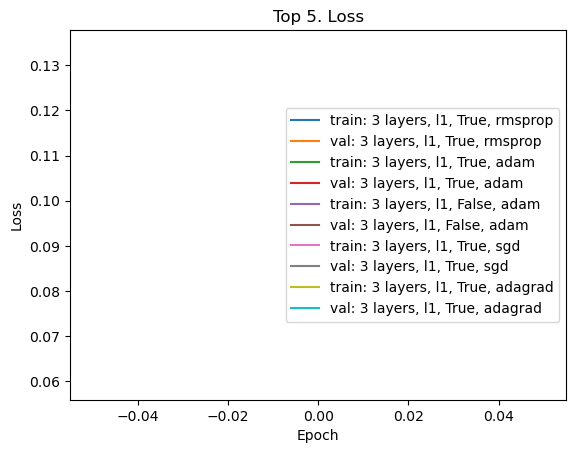

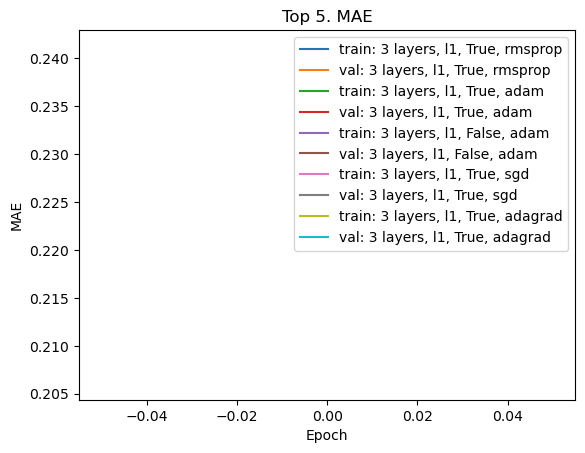

In [107]:
# plot results for the different models

for i, result in enumerate(df_result.values[0:5]):
    label = str(result[0]) + " layers, " + str(result[1]) + ", " + str(result[2]) + ", " + str(result[3])
    plt.plot(train_loss[i], label="train: " + label)
    plt.plot(val_loss[i], label="val: " + label)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Top 5. Loss")
plt.legend()
plt.show()
for i, result in enumerate(df_result.values[0:5]):
    label = str(result[0]) + " layers, " + str(result[1]) + ", " + str(result[2]) + ", " + str(result[3])
    plt.plot(train_mae[i], label="train: " + label)
    plt.plot(val_mae[i], label="val: " + label)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title("Top 5. MAE")
plt.show()

# VAE

## Setup

In [13]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.decoder = decoder
    
    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar
        
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

## Loss function

In [14]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)

    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Train function

In [15]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Showing Progress

In [26]:
def generate_and_show_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    #for i in range(predictions.shape[0]):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.suptitle("Predicted image")

    plt.show()
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(test_sample[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.suptitle("Original image")

    plt.show()

## 2D latensplot

In [17]:
def plot_2d_latent_images(model, n, image_size=28):
    grid_x = tf.math.ndtri(np.linspace(0.05, 0.95, n))
    grid_y = tf.math.ndtri(np.linspace(0.05, 0.95, n))
    image_width = image_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (image_size, image_size))
            image[i * image_size: (i + 1) * image_size, j * image_size: (j + 1) * image_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

## Model

In [127]:
def create_VAE(latent_dim, nb_layers=2, nb_filters=[32,32], kernel_size=(3,3), input_shape=(96,96,3), batch_normalization=False, Regularization=None, optimizer=tf.keras.optimizers.Adam(1e-4)):
#    encoder = tf.keras.models.Sequential([
#        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, activation='relu', padding='same', input_shape=(96, 96, 3)),
#        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same',),
#        tf.keras.layers.Flatten(),
#        tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
#    ])
#    encoder.summary()
#    decoder = tf.keras.models.Sequential([
#        tf.keras.layers.Dense(units=24*24*32, activation='relu', input_shape=(latent_dim,)),
#        tf.keras.layers.Reshape(target_shape=(24, 24, 32)), # To get in "image format"
#        tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
#        tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
#        tf.keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=1, padding='same'),
#    ])
#    decoder.summary()

# ENCODER
    encoder = tf.keras.Sequential(name='encoder')
    encoder.add(tf.keras.layers.Conv2D(filters=nb_filters[0],
                                       kernel_size=kernel_size,
                                       strides=2, padding='same',
                                       activation='relu',
                                       input_shape=input_shape))
    for i in range(1,nb_layers):
        if Regularization == 'l1':
            encoder.add(tf.keras.layers.Conv2D(filters=nb_filters[i],
                                               kernel_size=kernel_size,
                                               strides=2,
                                               padding='same',
                                               activation='relu',
                                               activity_regularizer=tf.keras.regularizers.l1(10e-5)))
        elif Regularization == 'l2':
            encoder.add(tf.keras.layers.Conv2D(filters=nb_filters[i],
                                               kernel_size=kernel_size,
                                               strides=2,
                                               padding='same',
                                               activation='relu',
                                               activity_regularizer=tf.keras.regularizers.l2(10e-5)))
        else:
            encoder.add(tf.keras.layers.Conv2D(filters=nb_filters[i], kernel_size=kernel_size, strides=2, padding='same', activation='relu'))

        if batch_normalization == True:
            encoder.add(tf.keras.layers.BatchNormalization())
    
    encoder.add(tf.keras.layers.Flatten())
    encoder.add(tf.keras.layers.Dense(2 * latent_dim)) # 2 since we encode mean and standard deviation
# END OF ENDODER

# DECODER
    decoder = tf.keras.Sequential(name='decoder')
    decoder.add(tf.keras.layers.Dense(units=input_shape[0]//2**nb_layers*input_shape[1]//2**nb_layers*32,
                          activation='relu',
                          input_shape=(latent_dim,)))
    decoder.add(tf.keras.layers.Reshape(target_shape=(input_shape[0]//2**nb_layers,input_shape[1]//2**nb_layers,32))) # To get in "image format"
    
    for i in range(nb_layers-1,-1,-1):
        if Regularization == 'l1':
            decoder.add(tf.keras.layers.Conv2DTranspose(filters=nb_filters[i],
                                                        kernel_size=kernel_size,
                                                        strides=2,
                                                        padding='same',
                                                        activation='relu',
                                                        activity_regularizer=tf.keras.regularizers.l1(10e-5)))
        elif Regularization == 'l2':
            decoder.add(tf.keras.layers.Conv2DTranspose(filters=nb_filters[i],
                                                        kernel_size=kernel_size,
                                                        strides=2,
                                                        padding='same',
                                                        activation='relu',
                                                        activity_regularizer=tf.keras.regularizers.l2(10e-5)))
        else:
            decoder.add(tf.keras.layers.Conv2DTranspose(filters=nb_filters[i], kernel_size=kernel_size, strides=2, padding='same', activation='relu'))
        if batch_normalization == True:
            decoder.add(tf.keras.layers.BatchNormalization())
    
    decoder.add(tf.keras.layers.Conv2DTranspose(filters=3,
                                                kernel_size=kernel_size,
                                                strides=1, padding='same',
                                                activation='sigmoid'))
    encoder.summary()
    decoder.summary()
# END OF DECODER
    model = VAE(latent_dim, encoder, decoder)
    return model

## Train VAE

In [128]:
latent_dims = [25]
nb_layers = [3]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [False]
Regularization = [None]
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results1.csv', index=False)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_200 (Conv2D)         (None, 48, 48, 32)        896       
                                                                 
 conv2d_201 (Conv2D)         (None, 24, 24, 32)        9248      
                                                                 
 conv2d_202 (Conv2D)         (None, 12, 12, 32)        9248      
                                                                 
 flatten_25 (Flatten)        (None, 4608)              0         
                                                                 
 dense_50 (Dense)            (None, 50)                230450    
                                                                 
Total params: 249,842
Trainable params: 249,842
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
____________________________________

KeyboardInterrupt: 

In [ ]:
latent_dims = [25]
nb_layers = [3]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [False]
Regularization = ['l2']
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results2.csv', index=False)


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_203 (Conv2D)         (None, 48, 48, 32)        896       
                                                                 
 conv2d_204 (Conv2D)         (None, 24, 24, 32)        9248      
                                                                 
 conv2d_205 (Conv2D)         (None, 12, 12, 32)        9248      
                                                                 
 flatten_26 (Flatten)        (None, 4608)              0         
                                                                 
 dense_52 (Dense)            (None, 50)                230450    
                                                                 
Total params: 249,842
Trainable params: 249,842
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
____________________________________

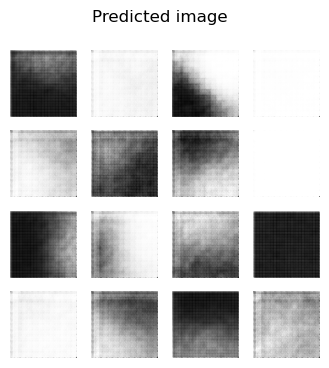

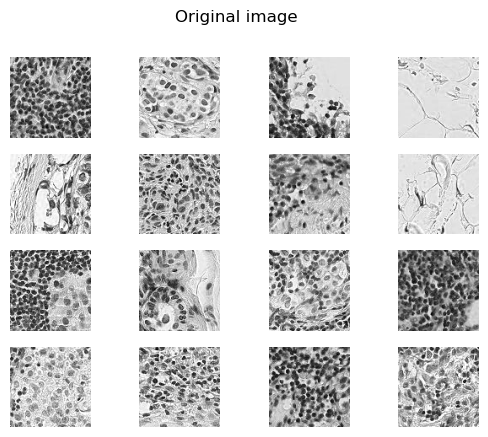

Epoch: 2, Test set variational lower bound: -17433.142578125, Time: 4.439690832297007 minuts


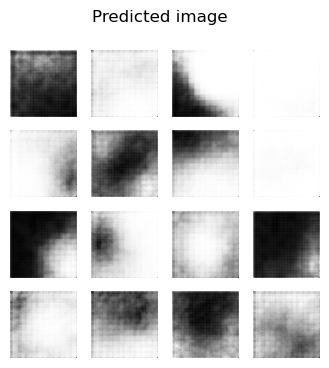

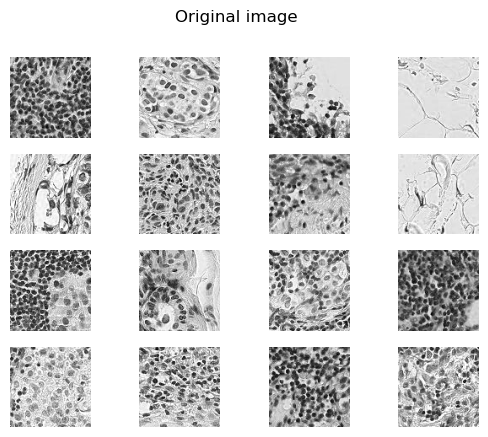

KeyboardInterrupt: 

In [129]:
latent_dims = [25]
nb_layers = [3]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [False]
Regularization = ['l1']
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results.csv3', index=False)


In [ ]:
latent_dims = [25]
nb_layers = [3]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [True]
Regularization = [None]
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results4.csv', index=False)


In [ ]:
latent_dims = [25]
nb_layers = [3]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [True]
Regularization = ['l2']
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results5.csv', index=False)


In [ ]:
latent_dims = [25]
nb_layers = [3]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [True]
Regularization = ['l1']
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results6.csv', index=False)


In [ ]:
latent_dims = [25]
nb_layers = [4]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [False]
Regularization = [None]
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results7.csv', index=False)


In [ ]:
latent_dims = [25]
nb_layers = [4]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [False]
Regularization = ['l2']
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results8.csv', index=False)

In [ ]:
latent_dims = [25]
nb_layers = [4]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [False]
Regularization = ['l1']
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results9.csv', index=False)

In [ ]:
latent_dims = [25]
nb_layers = [4]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [True]
Regularization = [None]
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results10.csv', index=False)

In [ ]:
latent_dims = [25]
nb_layers = [4]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [True]
Regularization = ['l2']
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results11.csv', index=False)

In [ ]:
latent_dims = [25]
nb_layers = [4]
nb_filters = [32,32,32,32]
kernel_size = (3,3)
input_shape = (96,96,3)
batch_normalization = [True]
Regularization = ['l1']
optimizers = [tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.RMSprop(1e-4), tf.keras.optimizers.Adagrad(1e-4)]

for batch in test_dataset.take(1):
    test_sample = batch[0]

epochs = 100 # EDIT THIS TO CHANGE NUMBER OF EPOCHS BEFORE RUNNING

results = []

for latent_dim in latent_dims:
    for nb_layer in nb_layers:
        for batch_norm in batch_normalization:
            for reg in Regularization:
                for opt in optimizers:
                    model = create_VAE(latent_dim, nb_layer, nb_filters, kernel_size, input_shape, batch_norm, reg)
                    print(f'Creating and Training VAE-model with {latent_dim} latent dimensions, {nb_layer} layers in encoder and decoder, batch_normalization: {batch_norm}, Regularization: {reg}, optimizer: {opt}')

                    for epoch in range(epochs):
                        start_time = time.time()
                        
                        for x in train_dataset:
                            train_step(model, x[0], opt)

                        loss = tf.keras.metrics.Mean()
                        for x in validation_dataset:
                            loss(compute_loss(model, x[0]))
                        variational_lower_bound = -loss.result()

                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print(f'Epoch: {epoch+1}, Test set variational lower bound: {variational_lower_bound}, Time: {elapsed_time/60} minuts')
                        generate_and_show_images(model, epoch, test_sample)
                    

                    results.append([latent_dim, nb_layers, Regularization, batch_normalization, optimizer, variational_lower_bound])
df_result = pd.DataFrame(results, columns=['latent_dim', 'nb_layers', 'Regularization', 'batch_normalization', 'optimizer', 'variational_lower_bound'])
df_result.sort_values(by=['variational_lower_bound'], inplace=True, ascending=False, ignore_index=True)
df_result.to_csv('VAE_results12.csv', index=False)